In [149]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import pyproj
from scipy import ndimage

In [150]:
input_raster = 'out_raster/filters/exg_filtered_sec.tif'
output_raster = 'out_raster/reclass/exg_reclass_sec.tif'

In [151]:
#from rasterio import features
with rasterio.open(input_raster) as dataset:
    vari = dataset.read(1).astype(np.float32)
    meta = dataset.meta
    nodata_vari = meta['nodata']  # Extract the nodata value

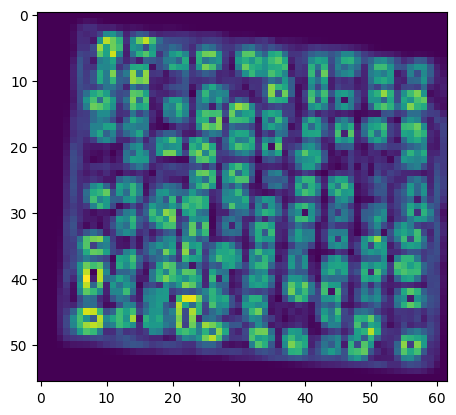

In [152]:
plt.imshow(vari)

In [153]:
reclass = np.zeros(dataset.shape, dtype=np.float32)

In [154]:
print('min', np.min(vari), 'max', np.max(vari))

min 0.0 max 22.219675


In [155]:
max_val = np.max(vari)
min_val = np.min(vari)
class_bins = np.linspace(0, max_val, 5)
print('class bins', class_bins)

class bins [ 0.          5.55491877 11.10983753 16.6647563  22.21967506]


In [156]:
# reclass levels with smooth edge exg
no_vegetation_vari = (vari > class_bins[0]) & (vari <= class_bins[1])
nitrogen_low_vari = (vari >= class_bins[1]) & (vari <= class_bins[2])
nitrogen_med_vari = (vari >= class_bins[2]) & (vari <= class_bins[3])
nitrogen_high_vari = (vari >= class_bins[3]) & (vari <= class_bins[4])

reclass[no_vegetation_vari] = (10)
reclass[nitrogen_low_vari] = (20)
reclass[nitrogen_med_vari] = (30)
reclass[nitrogen_high_vari] = (40)

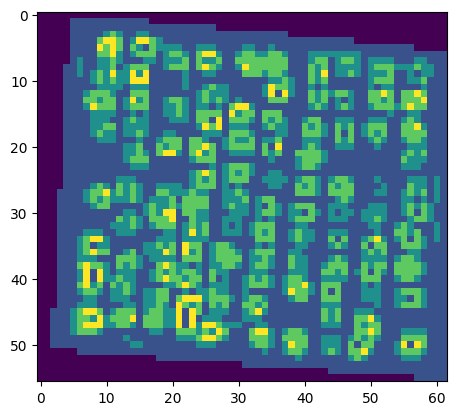

In [157]:
plt.imshow(reclass)

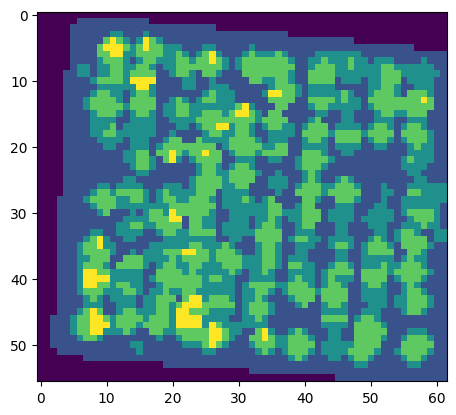

In [158]:
smooth_data = ndimage.gaussian_filter(reclass, sigma=1)
smooth_data = ndimage.median_filter(reclass, size=2)
plt.imshow(smooth_data)

In [160]:
#### VARI EXPORT
new_tiff_profile_vari = dataset.profile  # Copy the profile from the original dataset
new_tiff_profile_vari.update(
                        dtype=rasterio.float32,  # Update the data type to match the VARI data
                        count=1,  # Only one band for VARI
                        compress='lzw',  # You can choose a compression method if needed
                        tiled=False,
                        blockysize=1,
                        nodata=0.0
)
new_crs = pyproj.CRS.from_epsg(32651)
new_tiff_profile_vari.update(crs=new_crs)

#export data to file
with rasterio.open(output_raster, 'w', **new_tiff_profile_vari) as new_tiff:
                            new_tiff.write(smooth_data, 1)